# EDA of the Inside Airbnb: Amsterdam dataset

## Motivation and Beneficiars

Amsterdam: one of top-10 cities ranked by quality of life (Numbeo 2023) and at the same time a major tourist destination.

Airbnb: a short-term rental service, one of the reasons of the Amsterdam housing crysis.

Several parties are interested in the housing market and can benefit from a data analysis of Airbnb's Amsterdam data:
- tourists
    - objective:
        - to stay in the best location for the lowest price;
    - analysis benefit:
        - to know the best neighbourhoods to stay in;
        - to know when to come to Amsterdam (the cheapest seasons).
- Airbnb hosts
    - objective:
        - to earn as much money per night as possible;
        - to get high scores from tourists.
    - analysis benefit:
        - to know the market state in their neighbourhood (the highest price one can set);
        - to what to pay attention to when serving a guest in order to recieve high scores;
        - to write a description which stands out.
- amsterdammers (represented by the city's administration and activists)
    - objective:
        - to keep prices in control;
        - to preserve high quality of life.
    - analysis benefit:
        - to track the state the neighbourhoods are in (to see if they are overpopulated / overpriced);
        - to identify illegal or malicious behaviour.
- expats
    - objective:
        - to find a cheap, quiet and convenient neighbourhood for long-term rental.
    - analysis benefit:
        - to know what neighbourhoods are overpriced due to tourists and hype.

### Housing Crysis Context

The city is flooded with tourists and migrants, but still tries to keep to its high urbanization standarts. Long time amsterdammers often find themselves too poor to continue living there. Migrants suffer as well -- even with a relatively high income housing prices noticeably hit the pocket. Among other things, as the old timers leave the area, it loses its authenticity (gentrification).

For the city, the most dangerous situation arises when a large amounts of living space is bought out by investors to rent it on short-term rentals. To fight this, the Amsterdam has ruled out that hosts can rent their entire apartements for up to 60 nights (2017-2018) and then up to 30 nights per year to a group of no more than four at a time. However, we must still try to detect and study purely commercial listings.

## About the Data

The dataset contains 7000 Amsterdam listings (each with 75 features) and 300k textual reviews from [airbnb.com](https://airbnb.com), scraped in March 2023. Oldest listings have reviews from as far as 2009. Additionally, for each listing, the dataset includes the price of stay for each day (night) since March 2023 till March 2024, as well as whether this day is available for booking, also scraped in March 2023.

The features descriptions can be found in this [sheet from Inside Airbnb](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596).

### About the Inside Airbnb project

From [insideairbnb.com](http://insideairbnb.com): 
> Inside Airbnb is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities.

More info on the project on [Wikipedia](https://en.wikipedia.org/wiki/Inside_Airbnb).

## Hypotheses

1. Neighbourhood Hypothesis:
    - center neighbourhoods grow linearly;
    - neighbourhoods far from the center are the least popular;
    - listings closer to the center are more expensive;
    - listings closer to the center receive higher location scores from tourists. 
2. Price Hypothesis:
    - large apartements are more expensive;
    - price is seasonal;
3. Rating Hypothesis: there are 7 different scores given by guests, but they are likely to be correlated with each other, and the overall score (a.k.a 'rating') can be devised from other scores.
4. Text Hypothesis: reviews reflect the quality of a listing.

# Preprocessing

In [400]:
from pathlib import Path
from json.decoder import JSONDecoder
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio


pio.renderers.default = 'iframe'


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english') + ['ha', 'wa', 'br', 'b'])


def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)


def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()


def draw_choropleth(feature, stat='mean', only_reviewed=False, title=None):
    stats = {
        'mean': pd.api.typing.DataFrameGroupBy.mean,
        'median': pd.api.typing.DataFrameGroupBy.median,
        'sum': pd.api.typing.DataFrameGroupBy.sum,
    }
    gb = stats[stat]((listings_reviewed if only_reviewed else listings).groupby(by='neighbourhood', as_index=False), feature)
    fig = px.choropleth_mapbox(gb, geojson=neighbourhoods_geojson, color=feature,
                           locations="neighbourhood", featureidkey="properties.neighbourhood",
                           center={"lat": 52.3676, "lon": 4.9041}, title=title or f'{feature} by neighbourhood',
                           mapbox_style="carto-positron", zoom=10, opacity=0.5)
    return fig.show()

In [91]:
data_dir = Path('data/netherlands/Amsterdam/')
calendar = pd.read_csv(data_dir / 'calendar.csv')
listings = pd.read_csv(data_dir / 'listings.csv')
listings_detailed = pd.read_csv(data_dir / 'listings_detailed.csv')
reviews = pd.read_csv(data_dir / 'reviews.csv')
reviews_detailed = pd.read_csv(data_dir / 'reviews_detailed.csv')
neighbourhoods = pd.read_csv(data_dir / 'neighbourhoods.csv')
neighbourhoods_geojson = JSONDecoder().decode((data_dir / 'neighbourhoods.geojson').read_text())

Let's look if we can drop the non-detailed datasets

In [92]:
set(listings.columns) - set(listings_detailed.columns)

{'neighbourhood_group'}

In [93]:
listings.neighbourhood_group.unique()

array([nan])

=> indeed we can drop non-detailed listings:

In [95]:
listings = listings_detailed.drop(columns=['neighbourhood']).rename(columns={'neighbourhood_cleansed': 'neighbourhood'})  # we will only need neighbourhood_cleansed

set(reviews.columns) - set(reviews_detailed.columns)

set()

In [96]:
reviews = reviews_detailed

In [97]:
for column in ['host_since', 'first_review', 'last_review']:
    listings[column] = pd.to_datetime(listings[column], format='%Y-%m-%d')
    listings[column].dt.day.describe()

calendar.date = pd.to_datetime(calendar.date, format='%Y-%m-%d')

listings.price = listings.price.replace('[\$,]', '', regex=True).astype(float)
calendar.price = calendar.price.replace('[\$,]', '', regex=True).astype(float)

We can see that 10% of all listings don't have any reviews and these are the same that don't have any scores:

In [127]:
listings.review_scores_rating.isnull().sum()

682

In [128]:
(listings.review_scores_rating.isnull() == (listings.number_of_reviews == 0)).all()

True

In [131]:
listings_reviewed = listings[listings.number_of_reviews > 0]

In [329]:
listings.shape, reviews.shape

((6962, 77), (339790, 7))

# Neighbourhoods Density

## Number of Listings by Neighbourhood

In [396]:
fig = px.histogram(listings, x="neighbourhood", category_orders={'neighbourhood': list(listings.neighbourhood.value_counts().index)}, title='Number of Listings by Neighbourhood')
fig.show()

In [397]:
gb = listings.neighbourhood.value_counts().reset_index()
fig = px.choropleth_mapbox(gb, geojson=neighbourhoods_geojson, color='count',
                       locations="neighbourhood", featureidkey="properties.neighbourhood",
                       center={"lat": 52.3676, "lon": 4.9041}, title=f'Size by Neighbourhood',
                       mapbox_style="carto-positron", zoom=10, opacity=0.5)
fig.show()

Let's leave top10 neighbourhoods for later visualizations:

In [195]:
top10_neighbourhoods = list(listings.neighbourhood.value_counts()[:10].index)
top10_neighbourhoods

['De Baarsjes - Oud-West',
 'Centrum-West',
 'De Pijp - Rivierenbuurt',
 'Centrum-Oost',
 'Westerpark',
 'Zuid',
 'Oud-Oost',
 'Bos en Lommer',
 'Oud-Noord',
 'Oostelijk Havengebied - Indische Buurt']

In [196]:
listings_in_top10_neighbourhoods = listings[listings.neighbourhood.isin(top10_neighbourhoods)]
len(listings_in_top10_neighbourhoods)

5823

## Neighbourhoods Yearly Growth

In [398]:
listings_reviewed.loc[:, 'first_review_year'] = listings_reviewed['first_review'].dt.year
gb = listings_reviewed.groupby(by=['first_review_year', 'neighbourhood'], as_index=False).size()
gb.first_review_year = gb.first_review_year.astype(int)
fig = px.choropleth_mapbox(gb, geojson=neighbourhoods_geojson, color='size',
                       locations="neighbourhood", featureidkey="properties.neighbourhood",
                       center={"lat": 52.3676, "lon": 4.9041}, title='Neighbourhoods Yearly Growth',
                       mapbox_style="carto-positron", zoom=10, opacity=0.5, animation_frame='first_review_year')
fig.show()

## Neighbourhoods Cumulative Yearly Growth

In [200]:
res = listings_reviewed.copy()
for year in range(2009, 2023):
    listings_at_year = listings_reviewed[listings_reviewed.first_review_year == year]
    ls = [res]
    for future_year in range(year + 1, 2024):
        l = listings_at_year.copy()
        l.first_review_year = future_year
        ls.append(l)
    res = pd.concat(ls)

In [399]:
fig = px.scatter_mapbox(res.sort_values('first_review_year', ascending=True), lat='latitude', lon='longitude', center={"lat": 52.3676, "lon": 4.9041}, #color="peak_hour", size="car_hours",
                        zoom=10, mapbox_style="carto-positron", animation_frame='first_review_year', opacity=0.25, title='Neighbourhoods Cumulative Yearly Growth')
fig.show()

# Neighbourhoods Popularity

## Total Number of Reviews by Neighbourhood (~Total Tourists Volume)

Here we approximate total tourists volume - the popularity of a neighbourhood.

In [401]:
draw_choropleth('number_of_reviews', 'sum', title='Total Number of Reviews by Neighbourhood (~Total Tourists Volume)')

## Median Number of Reviews by Neighbourhood (~Listings Experience)

In [402]:
draw_choropleth('number_of_reviews', 'median', title='Median Number of Reviews by Neighbourhood (~Listings Experience)')

## Total Number of Reviews Per Month by Neighbourhood (~Monthly Airbnb Guests Volume)

In [359]:
listings_reviewed['lifetime_in_months'] = ((listings_reviewed.last_review - listings_reviewed.first_review)/np.timedelta64(1, 'D'))/30 + 1/30
listings_reviewed['load'] = listings_reviewed['number_of_reviews'] / np.ceil(listings_reviewed['lifetime_in_months'])

In [404]:
draw_choropleth('load', 'sum', only_reviewed=True, title='Total Number of Reviews Per Month by Neighbourhood (~Monthly Airbnb Guests Volume)')

## Median Number of Reviews Per Month by Neighbourhood (~Listing Busyness)

In [405]:
draw_choropleth('load', 'median', only_reviewed=True, title='Median Number of Reviews Per Month by Neighbourhood (~Listing Busyness)')

# Neighbourhoods Expensiveness

## Median Price by Neighbourhood

In [406]:
draw_choropleth('price', 'median', title='Median Price by Neighbourhood')

### Price Distribution by Neighbourhood

In [407]:
fig = px.violin(listings_in_top10_neighbourhoods, y="price", x="neighbourhood", log_y=False, range_y=[-10, 2000], points="all", box=True, title='Price Distribution by Neighbourhood',
               category_orders={'neighbourhood': list(listings_in_top10_neighbourhoods.groupby('neighbourhood')['price'].aggregate('median').reset_index().sort_values(by='price')['neighbourhood'])}
)
fig.show()

# Neighbourhoods Scores From Tourists

## Median Location Scores by Neighbourhood

In [408]:
draw_choropleth('review_scores_location', 'median', title='Median Location Scores by Neighbourhood')

### Location Score Distribution by Neighbourhood

In [410]:
fig = px.violin(listings, y="review_scores_location", x="neighbourhood", box=True, points="all", range_y=[3, 5.5], title='Location Score Distribution by Neighbourhood',
               category_orders={'neighbourhood': list(listings.groupby('neighbourhood')['review_scores_location'].aggregate('mean').reset_index().sort_values(by='review_scores_location')['neighbourhood'])}
)
fig.show()

# Price

## Price Distribution 

In [43]:
listings.price.isnull().any()  # no NaNs

False

In [411]:
fig = px.histogram(listings, x='price', nbins=1000, barmode='group', range_x=[0, 500], histnorm='probability', title='Price Distribution')
fig.show()

In [412]:
fig = px.histogram(listings, x='price', nbins=100, barmode='group', range_x=[0, 500], histnorm='probability', title='Price Distribution')
fig.show()

### Price Outliers
#### Zero Price

In [239]:
listings[listings.price == 0][['price', 'name', 'review_scores_rating', 'number_of_reviews', 'description', 'instant_bookable', 'has_availability', 'room_type', 'id']]

,price,name,review_scores_rating,number_of_reviews,description,instant_bookable,has_availability,room_type,id
4088,0.0,Dutchies Hostel,4.38,609,NaN,f,t,Hotel room,42430386
4093,0.0,Hotel Abba,4.34,318,NaN,f,t,Hotel room,42431273
4094,0.0,Melrose Hotel,4.58,84,NaN,f,t,Hotel room,42431450
4139,0.0,Acostar Hotel,NaN,0,NaN,f,t,Hotel room,43095925
4439,0.0,Sir Albert,5.00,7,NaN,f,t,Hotel room,47110768


In [238]:
calendar[calendar.listing_id == 42430386].price.mean()

0.0

We can see that there are only 5 listings with zero price. All of them are not instantly bookable and all of them are hotels, so in reality this is probably either a bug or hotel marketing strategy. Either way, let's drop them as outliers.

In [242]:
listings = listings[listings.price > 0]

#### More than 1000 EUR per night

In [45]:
listings[listings.price > 1000].sample(5)[['price', 'name', 'review_scores_rating', 'number_of_reviews']]

,price,name,review_scores_rating,number_of_reviews
5644,1307.0,Grand 4 Bedroom Townhouse with a Roof Terrace,5.00,13
2983,1057.0,"Exclusive room with sauna, City Center-canal view",5.00,4
5936,1071.0,Luxurious 3 floor loft in the city centre,4.67,3
5587,2656.0,Enjoy ShipStays Hotel in Amsterdam!,NaN,0
4983,2350.0,Luxury villa 5 mts walk from RAI,NaN,0


Let's drop listings with high price as outliers.

In [264]:
listings = listings[listings.price < 1000]

## Price Fluctuations by Season

In [414]:
calendar.groupby(by='date').size()[calendar.groupby(by='date').size() == 6998]
None

Let's leave only the range with the same number of listings: from 2023-03-26 to 2024-03-07.

In [415]:
calendar = calendar[(calendar.date >= '2023-03-26') & (calendar.date <= '2024-03-07')]
calendar.groupby(by='date').size().value_counts()

6998    348
Name: count, dtype: int64

In [416]:
listing_avg_price = calendar[['listing_id', 'price']].groupby(by='listing_id').mean().rename(columns={'price': 'avg_price'})

In [417]:
calendar = calendar.join(listing_avg_price, on='listing_id', validate='m:1')

In [418]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,avg_price
17,2818,2023-03-26,f,69.0,$69.00,3.0,1125.0,68.864943
18,2818,2023-03-27,f,69.0,$69.00,3.0,1125.0,68.864943
19,2818,2023-03-28,f,69.0,$69.00,3.0,1125.0,68.864943
20,2818,2023-03-29,f,69.0,$69.00,3.0,1125.0,68.864943
21,2818,2023-03-30,f,69.0,$69.00,3.0,1125.0,68.864943


In [419]:
calendar['dprice'] = ((calendar.price - calendar.avg_price) / calendar.avg_price) * 100

In [420]:
fig = px.histogram(calendar.sort_values(by='date'), x='date', y='dprice', histfunc='avg', title='Price Fluctuation by Season')
fig.show()

# Reviews

## Rating by Number of Reviews

In [422]:
listings_reviewed.loc[:, 'number_of_reviews_jittered'] = listings_reviewed.number_of_reviews + np.exp(np.random.randn(len(listings_reviewed)) / 10)
listings_reviewed.loc[:, 'review_scores_rating_jittered'] = listings_reviewed.review_scores_rating + np.random.randn(len(listings_reviewed)) / 10
fig = px.scatter(listings_reviewed[listings_reviewed.price < 1000], x='number_of_reviews_jittered', y='review_scores_rating_jittered', color='lifetime_in_months', log_x=True, opacity=0.25, marginal_x='box', marginal_y='histogram', title='Rating by Number of Reviews')
fig.show()

## Review Scores Correlations

The review scores columns are the following:

```
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
```

The `review_scores_rating` is the overall rating given by the guest, not an aggregate of the rest of the scores, which rate aspects separately.

In [423]:
aspect_scores_feats = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
scores_feats = ['review_scores_rating'] + aspect_scores_feats
px.imshow(listings[scores_feats].corr(), title='Review Scores Correlations')

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pprint import pprint

def calc_prediction_quality(X_feats, y_feat):
    df = listings[X_feats + [y_feat]].dropna(how='any')
    X_train, X_test, y_train, y_test = train_test_split(df[X_feats], df[y_feat], test_size=0.33, random_state=42)
    lr = LinearRegression().fit(X_train, y_train)
    mse = mean_squared_error(y_test, lr.predict(X_test))
    print(f'constant model MSE: {mean_squared_error(y_test, [y_train.mean()] * len(y_test))}')
    print(f'LR MSE: {mse}')
    print(f'LR intercept: {lr.intercept_}')
    print(f'LR weights:')
    pprint(dict(zip(aspect_scores_feats, lr.coef_)))

calc_prediction_quality(aspect_scores_feats, 'review_scores_rating')

constant model MSE: 0.05333939001310831
LR MSE: 0.0144379211774466
LR intercept: 0.27497301151518183
LR weights:
{'review_scores_accuracy': 0.4121405304356848,
 'review_scores_checkin': 0.03137086989412066,
 'review_scores_cleanliness': 0.21498680781308416,
 'review_scores_communication': 0.16173630383523824,
 'review_scores_location': 0.0013978233721231026,
 'review_scores_value': 0.12383375563298774}


This means that `review_scores_rating` is in fact almost an aggregate of 4 most important features: `review_scores_accuracy`, `review_scores_cleanliness`, `review_scores_communication`, `review_scores_value`.

Let's visualize them with SVD:

In [ ]:
px.scatter(listings, x='review_scores_accuracy', y='review_scores_cleanliness', color='review_scores_rating', opacity=0.5)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

def plot_svd(feats):
    df = listings[feats].dropna(how='any')
    transformer = TruncatedSVD(n_components=2)
    transformer = PCA(n_components=2)
    data = transformer.fit_transform(df)
    fig = px.scatter(x=data[:, 0], y=data[:, 1])
    return fig.show()

In [ ]:
plot_svd(['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_value'])

## Rating Increases with Price, Value Doesn't

In [424]:
px.histogram(listings, x='price', y=['review_scores_rating', 'review_scores_value'], histfunc='avg', range_x=[0, 750], range_y=[4.2, 5], nbins=100, barmode='overlay', title='Rating and Value Score by Price').show()

## Average Price by Rating

In [425]:
px.histogram(listings, y='price', x='review_scores_rating', histfunc='avg', range_y=[0, 750], range_x=[4.2, 5], nbins=1000, title='Average Price by Rating')


# Listings Lifetimes

## Number of Reviews per Month by Price

In [372]:
listings_reviewed.loc[:, 'load_jittered'] = listings_reviewed.load + np.random.randn(len(listings_reviewed)) / 5
listings_reviewed.loc[:, 'price_jittered'] = listings_reviewed.price + np.random.randn(len(listings_reviewed)) * 2

In [426]:
px.histogram(listings_reviewed, x='price', y='load', histfunc='avg', range_x=[0, 300], range_y=[0, 10], nbins=2500, title='Number of Reviews per Month by Price').show()

## Number of Reviews by Active Lifetime

In [427]:
px.scatter(listings_reviewed, x='lifetime_in_months', y='number_of_reviews', color='price', range_color=[0, 300], range_y=[0, 1000], opacity=0.5, title='Number of Reviews by Active Lifetime').show()

## Active Lifetime In Months

We can calculate the active lifetime of a listing by counting the month between the first and the last review.

In [428]:
fig = px.histogram(listings_reviewed, x='lifetime_in_months', nbins=int(listings_reviewed.lifetime_in_months.max()), barmode='group', marginal='box', title='Active Lifetime In Months')
fig.show()

## Listings Lifetimes Scatter

In [430]:
fig = px.scatter(listings, x='first_review', y='last_review', marginal_x='histogram', marginal_y='histogram', title='Listings Lifetimes Scatter')
fig.show()

# Objective Listing Properties

## Listing Types

In [431]:
fig = px.histogram(listings, x='property_type', color='room_type', barmode='group', title='Listing Types')
fig.show()

## Price by Capacity

In [432]:
fig = px.box(listings, x='accommodates', y='price', range_y=[0, 1000], range_x=[0, 9], title='Price by Capacity')
fig.show()

# Texts

## Name and Description Texts

In [102]:
listings['listing_name'] = listings.name.astype('string')

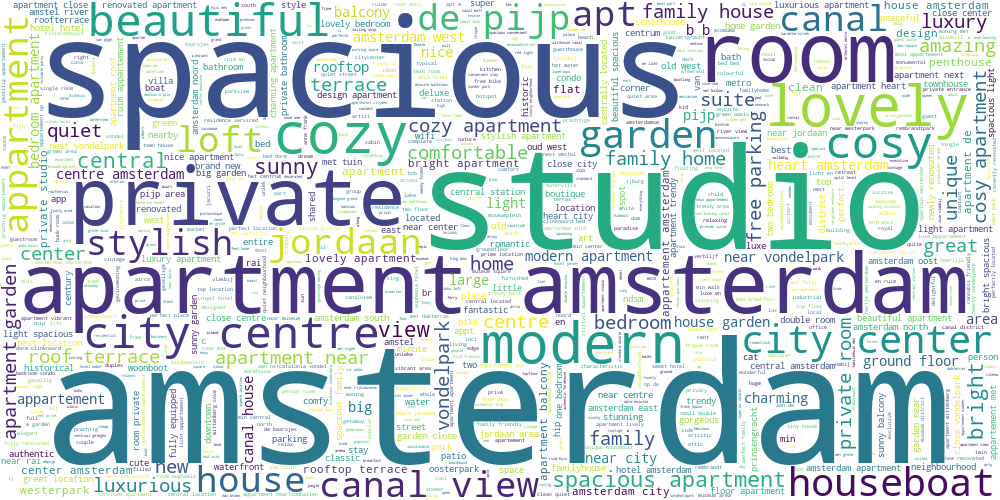

In [103]:
draw_wordcloud(listings.apply(lambda row: preprocess(row.listing_name), axis=1))

In [105]:
listings.description.isnull().sum()

6

In [107]:
listings = listings.dropna(subset=['description'])
listings.description = listings.description.astype('string')

/tmp/ipykernel_1011985/1067013331.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



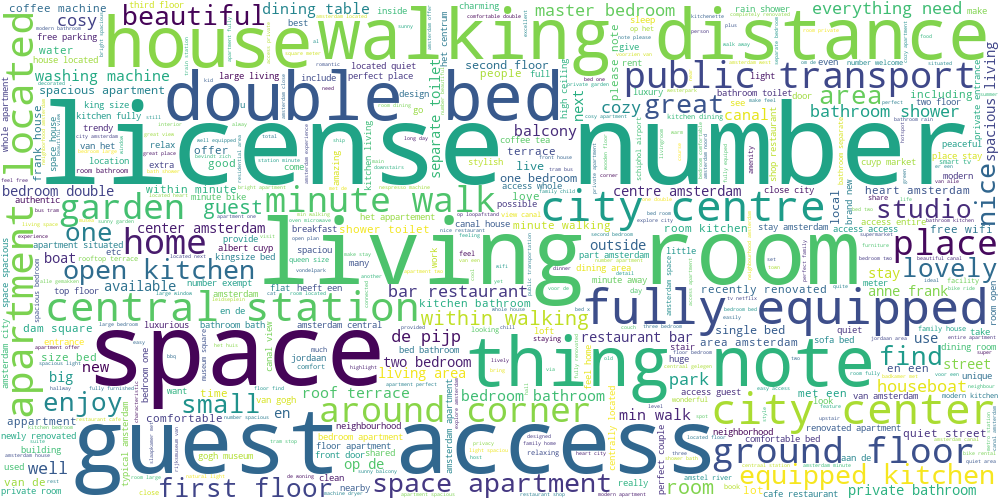

In [110]:
draw_wordcloud(listings.apply(lambda row: preprocess(row.description), axis=1))

## Individual Reviews Texts

In [99]:
reviews.sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
244427,25310429,315533013,2018-08-29,211148873,David,Excellent location
336456,680955535725338595,835360940460548249,2023-02-26,484166769,Samuel,Wonderful
139763,8792777,709253796792471569,2022-09-05,20785370,Emily,best place to stay in Amsterdam!
73775,1783438,11013834,2014-03-17,12263157,Will,"We had a great stay at this place, it's just a..."
92201,3926355,604847516275503776,2022-04-14,23970772,Elizabeth,"What a cool space! Beyond looking really cool,..."


In [100]:
reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         15
dtype: int64

In [433]:
reviews = reviews.dropna()
reviews.loc[:, 'length'] = reviews.comments.str.len()

In [435]:
fig = px.histogram(reviews[reviews.length != 0], x='length', nbins=1000, barmode='group', title='Length of Reviews')
fig.show()

In [81]:
reviews = reviews[reviews.length < 750]

In [82]:
reviews_with_rating = reviews.join(listings[['id', 'review_scores_rating']].set_index('id'), on='listing_id', validate='m:1')

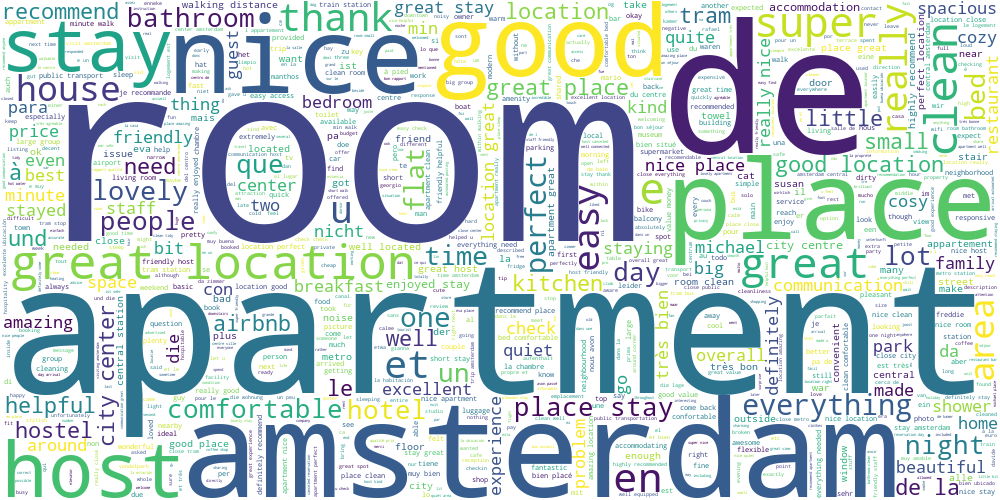

In [85]:
draw_wordcloud(reviews_with_rating[reviews_with_rating.review_scores_rating < 4.3].apply(lambda row: preprocess(row.comments), axis=1))

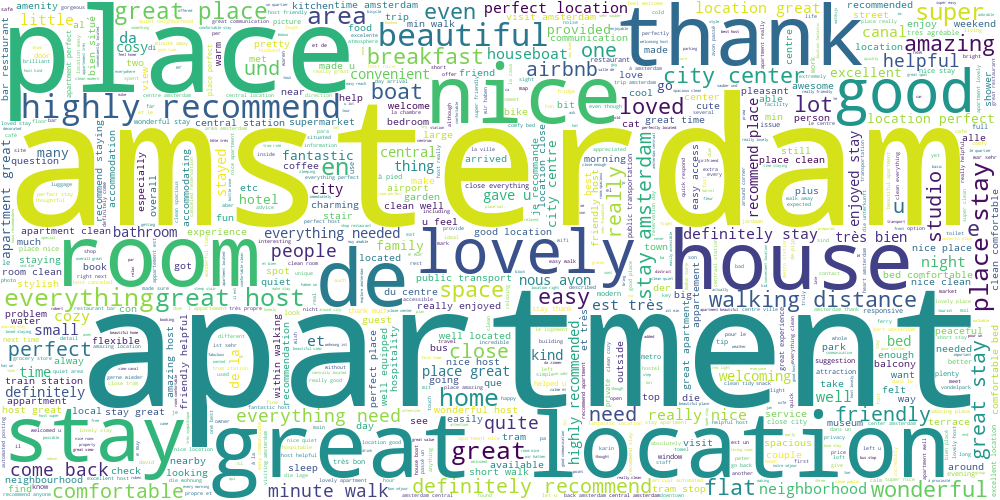

In [86]:
draw_wordcloud(reviews_with_rating[reviews_with_rating.review_scores_rating > 4.3].sample(10000).apply(lambda row: preprocess(row.comments), axis=1))

# Meta Features

Listings' table includes meta features `id`, `scrape_id`, `last_scraped`, `listing_url`, `license` and `source`, as well as `picture_url`. I am going to see whether they affect the listings' distribution. 

### id

In [ ]:
fig = px.histogram(listings, x="id")
fig.show()

In [ ]:
fig = px.histogram(listings[listings.id < 10**17], x="id")
fig.show()

In [ ]:
listings['is_old'] = listings.id < 10**17
fig = px.histogram(listings, x="first_review", color='is_old', barmode='group')
fig.show()

First review is an approximation of the listings' age.

We can infer that Airbnb recently switched the id generation scheme, so this new feature can help approximate the listings' age.

### scrape_id, last_scraped

In [ ]:
listings.scrape_id.unique()

=> We can throw away `scrape_id`

In [84]:
listings.last_scraped.value_counts()

last_scraped
2023-03-10    4989
2023-03-09    2008
2023-03-26       1
Name: count, dtype: int64

Almost always scrape date differs at most by 1 day. Let's look whether it influences the most important value of a listing, it's rating:

In [164]:
fig = px.histogram(listings, x='review_scores_rating', color='last_scraped', nbins=30, barmode='group', histnorm='probability')
fig.show()

/nix/store/v263fm7zbkvvw7s6f778bq9r7ai2b5zk-python3-3.11.1-env/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



=> `scrape_date` probably doesn't influence the distribution.

### source

In [107]:
listings.source.value_counts()

source
city scrape        4285
previous scrape    2713
Name: count, dtype: int64

In [165]:
fig = px.histogram(listings, x='review_scores_rating', color='source', nbins=30, barmode='group', histnorm='probability')
fig.show()

/nix/store/v263fm7zbkvvw7s6f778bq9r7ai2b5zk-python3-3.11.1-env/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Similarly, let's just ignore it.

### listing_url

Let's check whether there are listings with the same url:

In [126]:
listings.shape[0] - listings.listing_url.nunique()

0

=> it doesn't matter

### picture_url

Let's do the same:

In [128]:
listings.shape[0] - listings.picture_url.nunique()

72

In [145]:
groups_with_duplicated_pictures = listings.groupby(by='picture_url').filter(lambda df:df.shape[0] > 1).groupby(by='picture_url')
list(groups_with_duplicated_pictures)[0][1][['id', 'name', 'description', 'review_scores_rating', 'first_review', 'property_type', 'license']]

,id,name,description,review_scores_rating,first_review,property_type,license
4551,49700139,"Private loft, free parking at central Vondelpark!",<b>Other things to note</b><br />Centrally sit...,4.40,2021-06-27,Private room in bed and breakfast,0363 F563 A65B 6D7E 73DB
4714,50666229,Private loft next @Vondelpark with PRIVATE par...,Vintage & private loft centrally situated in t...,4.91,2021-08-01,Private room in bed and breakfast,0363 F563 A65B 6D7E 73DB


In [146]:
list(groups_with_duplicated_pictures)[1][1][['id', 'name', 'description', 'review_scores_rating', 'first_review', 'property_type', 'license']]

,id,name,description,review_scores_rating,first_review,property_type,license
1165,8744580,"White spacious apartment, east Amsterdam (100m2)",Located in the lively multi cultural Transvaal...,4.9,2015-10-21,Entire condo,0363 AA89 A799 7DC7 54C8
3768,38516801,White spacious apartment in Amsterdam East (kids),White spacious apartment in Amsterdam East<br ...,NaN,NaN,Entire condo,0363 AA89 A799 7DC7 54C8


In [147]:
list(groups_with_duplicated_pictures)[2][1][['id', 'name', 'description', 'review_scores_rating', 'first_review', 'property_type', 'license']]

,id,name,description,review_scores_rating,first_review,property_type,license
1494,13353566,Amsterdam City & Rural Life Combined. Free Par...,Sleeping under Stars & Free Parking! Authentic...,4.68,2017-10-31,Private room in home,0363 6C05 84EB 97A6 B302
4568,48514864,Sleeping under Stars in Rural Amsterdam,Sleeping under Stars & Free Parking! Authentic...,5.00,2021-07-01,Private room in home,0363 6C05 84EB 97A6 B302
4976,53007617,Sleeping under the Amsterdam Stars- Free Parking!,Sleeping under Stars & Free Parking! Authentic...,5.00,2022-07-04,Private room in home,0363 6C05 84EB 97A6 B302
4987,53090192,Amsterdam Sleeping under Stars. Free Parking!,Sleeping under Stars & Free Parking! Authentic...,4.80,2022-03-21,Private room in home,0363 6C05 84EB 97A6 B302


Probably it's either similar rooms / condos rented. While in case of entire apartement rental this may look suspiciously commercial, i.e. the host keeps the property only for selling, which is illegal, it's a too small phenomena to study.

### license

In [153]:
listings.shape[0] - listings.license.nunique()

1035

In [154]:
listings.sample(20).license

3320                      Exempt
1475    0363 97B5 C516 A2BC 4704
3366    0363 28F5 235E 7495 AD39
6715    0363 FFD8 FC29 E3F0 276F
3120    0363 5E4E 01B5 4FBF 3E31
2842    0363 66A6 3B1B F649 6CE6
530     0363 728D 4AB8 8EF2 B8A7
4913    0363 520A 2564 65BE 5714
203     0363 2A3E E12A B662 839B
3567    0363 72BA 084C 4A41 DF1E
2935    0363 5E0B 7C35 9F40 B47D
2821    0363 0CA4 D69A B4DB 8D10
2995        0363AB4FE2C16A7224CE
6158    0363 D71B 8F07 F368 7C56
5204    0363 020E 8707 14DD 09C3
5274    0363 D83A 9BD6 03F6 5253
375         03633ED44B7A5874E126
6325                      Exempt
2420    0363 6A4B 3BF9 5007 9568
6137    0363 6A1A 1A78 17F0 168B
Name: license, dtype: object

In [155]:
listings.license[listings.license.str.len() < 20].value_counts()

license
Exempt    580
Name: count, dtype: int64

So the `license` field is either `Exempt` or the license number. Clearly we may need only a boolean feature `is_exempt`. Let's look whether it affects the distribution.

In [437]:
listings['is_exempt'] = listings.license == 'Exempt'

In [438]:
fig = px.histogram(listings, x='review_scores_rating', color='is_exempt', nbins=60, barmode='group', histnorm='probability')
fig.show()

It seems that exempt listings are of poorer quality.